In [12]:
# Import libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import os

from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, SimpleRNN
from keras.applications import imagenet_utils, ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam


In [13]:
file_path = 'spectrograms.h5'

with h5py.File(file_path, 'r') as f:
    
    bkcchi_shape = f['bkcchi'].shape
    print("Shape of 'Black-capped Chickadee':", bkcchi_shape)


    daejun_shape = f['daejun'].shape
    print("Shape of 'Dark-eyed Junco:", daejun_shape)

Shape of 'Black-capped Chickadee': (256, 343, 57)
Shape of 'Dark-eyed Junco: (256, 343, 58)


In [14]:
# Load the spectrogram data

f = h5py.File(file_path, 'r')

# Inspect the keys in the dataset
species_keys = list(f.keys())
print(species_keys)


['amecro', 'barswa', 'bkcchi', 'blujay', 'daejun', 'houfin', 'mallar3', 'norfli', 'rewbla', 'stejay', 'wesmea', 'whcspa']


In [15]:
# Select one species to inspect
selected_species_key = species_keys[2]
dset = f[selected_species_key]

# Check the shape of the dataset
print(dset.shape)


(256, 343, 57)


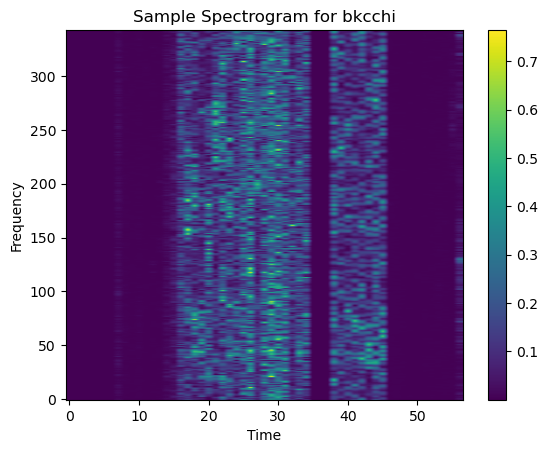

In [16]:
# Visualize a sample spectrogram
sample_spectrogram = dset[2]
plt.imshow(sample_spectrogram, aspect='auto', origin='lower')
plt.title(f'Sample Spectrogram for {selected_species_key}')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

In [17]:
# Select one species to inspect
selected_species_key = species_keys[4]
dset = f[selected_species_key]

# Check the shape of the dataset
print(dset.shape)

(256, 343, 58)


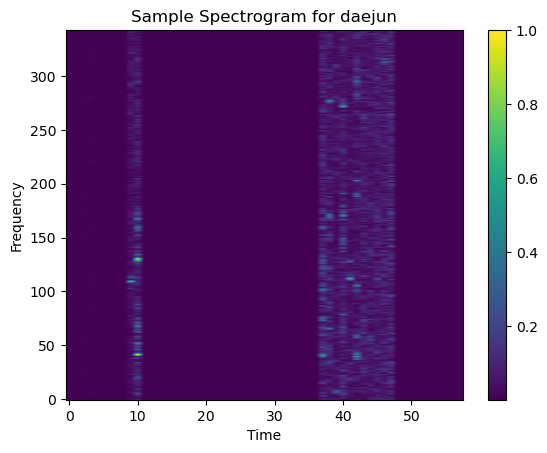

In [18]:
# Visualize a sample spectrogram
sample_spectrogram = dset[4]
plt.imshow(sample_spectrogram, aspect='auto', origin='lower')
plt.title(f'Sample Spectrogram for {selected_species_key}')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

# Binary Model


In [4]:
with h5py.File(file_path, 'r') as f:

    bkcchi_data = np.transpose(f['bkcchi'][:], (2, 0, 1))[..., np.newaxis]
    daejun_data = np.transpose(f['daejun'][:], (2, 0, 1))[..., np.newaxis]
    print("Reshaped 'Black-capped Chickadee':", bkcchi_data.shape)
    print("Reshaped 'Dark-eyed Junco':", daejun_data.shape)


Reshaped 'Black-capped Chickadee': (57, 256, 343, 1)
Reshaped 'Dark-eyed Junco': (58, 256, 343, 1)


In [5]:
# Normalize the data by the maximum value in the dataset
bkcchi_data_norm = bkcchi_data / np.max(bkcchi_data)
daejun_data_norm = daejun_data / np.max(daejun_data)


In [6]:
# Create labels for 'bkcchi' and 'daejun' species, Labels: 0 for 'bkcchi', 1 for 'daejun'
labels_bkcchi = np.zeros(bkcchi_data_norm.shape[0])
labels_daejun = np.ones(daejun_data_norm.shape[0])

# Concatenate data and labels
data = np.concatenate((bkcchi_data_norm, daejun_data_norm), axis=0)
labels = np.concatenate((labels_bkcchi, labels_daejun), axis=0)

In [7]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [14]:
# Build and Train Binary Classification Model

binary_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 343, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

D:\Jupiter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
binary_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = binary_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 13s/step - accuracy: 0.4915 - loss: 0.7029 - val_accuracy: 0.3684 - val_loss: 0.7170
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 10s/step - accuracy: 0.5137 - loss: 0.6969 - val_accuracy: 0.3684 - val_loss: 0.7664
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.5659 - loss: 0.6576 - val_accuracy: 0.7368 - val_loss: 0.5348
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 11s/step - accuracy: 0.7614 - loss: 0.5428 - val_accuracy: 0.7895 - val_loss: 0.5408
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.7666 - loss: 0.4577 - val_accuracy: 0.8947 - val_loss: 0.4234
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 10s/step - accuracy: 0.9048 - loss: 0.3516 - val_accuracy: 0.7895 - val_loss: 0.3868
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 16s/step - accuracy: 0.9140 - loss: 0.2110 - val_accuracy: 0.7368 - val_loss: 0.4080
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.9570 - loss: 0.1427 - val_accuracy: 0.8947 - val_loss: 0.3328
E

In [17]:
# Evaluating the binary model on the validation set.
score = binary_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(score[1]*100))

Test Accuracy: 86.96%


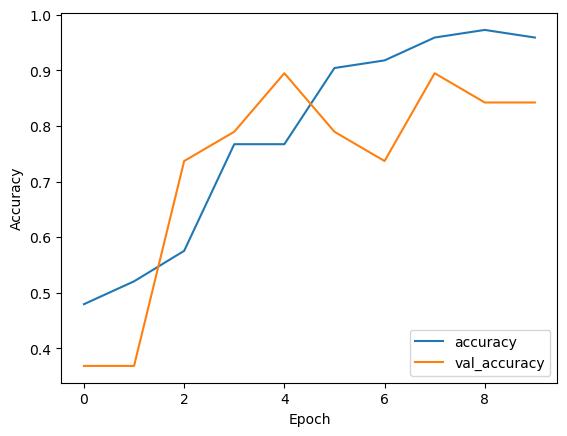

In [18]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

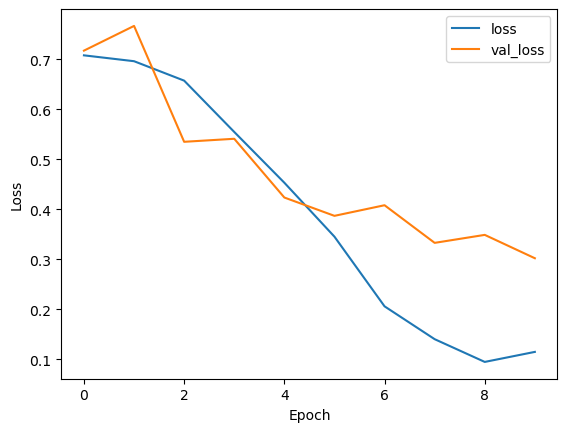

In [19]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show();

In [9]:
# Hyperparameter tuning binary

# Binary Model Hyperparameter Comparison
# Define a list of hyperparameters to tune
batch_sizes = [8, 16, 32]
filter_sizes = [(3, 3)]
num_filters = [8, 16, 32]
dense_units = [16, 32]
dropout_rates = [0.3, 0.5]

# Initialize variables to store the best hyperparameters and corresponding performance
best_accuracy_binary = 0
best_hyperparameters_binary = {}

# Iterate over hyperparameter combinations
for batch_size in batch_sizes:
    for filter_size in filter_sizes:
        for num_filter in num_filters:
            for dense_unit in dense_units:
                for dropout_rate in dropout_rates:
                    # Build the model
                    binary_model = Sequential([
                        Conv2D(num_filter, filter_size, activation='relu', input_shape=(256, 343, 1)),
                        MaxPooling2D((2, 2)),
                        Conv2D(num_filter*2, filter_size, activation='relu'),
                        MaxPooling2D((2, 2)),
                        Conv2D(num_filter*4, filter_size, activation='relu'),
                        Flatten(),
                        Dense(dense_unit, activation='relu'),
                        Dropout(dropout_rate),
                        Dense(1, activation='sigmoid')
                    ])
                    
                    # Compile the model
                    binary_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
                    
                    # Train the model
                    history = binary_model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2, verbose=0)
                    
                    # Evaluate the model on the validation set
                    accuracy = history.history['val_accuracy'][-1]
                    
                    # Check if this combination of hyperparameters improved performance
                    if accuracy > best_accuracy_binary:
                        best_accuracy_binary = accuracy
                        best_hyperparameters_binary = {
                            'batch_size': batch_size,
                            'filter_size': filter_size,
                            'num_filter': num_filter,
                            'dense_unit': dense_unit,
                            'dropout_rate': dropout_rate
                        }

# Print the best hyperparameters and corresponding performance for the binary model
print("Best Hyperparameters for Binary Model:")
print(best_hyperparameters_binary)
print("Best Validation Accuracy:", best_accuracy_binary)


Best Hyperparameters for Binary Model:
{'batch_size': 16, 'filter_size': (3, 3), 'num_filter': 16, 'dense_unit': 16, 'dropout_rate': 0.3}
Best Validation Accuracy: 0.9473684430122375


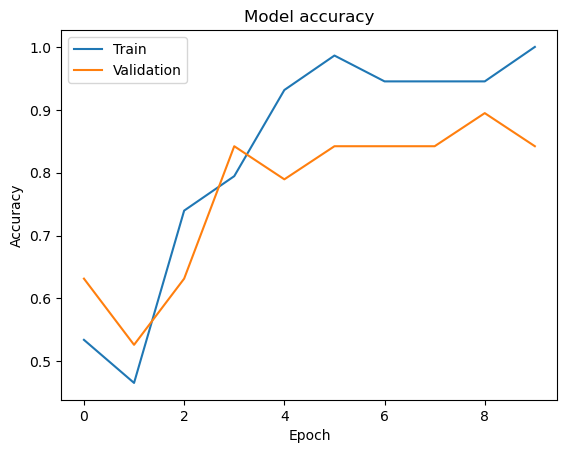

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

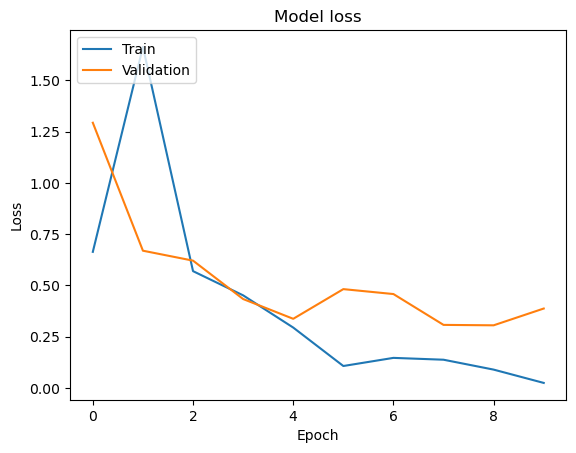

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Multiclass Model


In [19]:
# Load the data
file_path = 'spectrograms.h5'

with h5py.File(file_path, 'r') as f:
    num_classes = len(f.keys())
    
    spectrogram_data = []
    spectrogram_labels = []
    
    for idx, key in enumerate(f.keys()):
        data = f[key][:]
        data = np.transpose(data, (2, 0, 1))  # Transpose to match the desired shape
        data = np.expand_dims(data, axis=-1)  # Add a channel dimension
        data = data / np.max(data)  # Normalize the data
        
        labels = np.full((data.shape[0],), idx)  # Create labels
        
        spectrogram_data.append(data)
        spectrogram_labels.append(labels)

    spectrogram_data = np.concatenate(spectrogram_data, axis=0)
    spectrogram_labels = np.concatenate(spectrogram_labels, axis=0)
    spectrogram_labels = to_categorical(spectrogram_labels, num_classes=num_classes)

# Split data into training and testing sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(spectrogram_data, spectrogram_labels, test_size=0.2, random_state=42)


In [24]:
multiclass_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 343, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
multiclass_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])



D:\Jupiter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
history = multiclass_model.fit(X_train_1, y_train_1, epochs=10, batch_size=16, validation_split=0.2)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1695 - loss: 2.4622 - val_accuracy: 0.4086 - val_loss: 2.0145
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5832 - loss: 1.6202 - val_accuracy: 0.5269 - val_loss: 1.4557
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6702 - loss: 1.0909 - val_accuracy: 0.5699 - val_loss: 1.2880
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7635 - loss: 0.8040 - val_accuracy: 0.5376 - val_loss: 1.7849
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8677 - loss: 0.5983 - val_accuracy: 0.5914 - val_loss: 1.7454
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8276 - loss: 0.6271 - val_accuracy: 0.6452 - val_loss: 1.5757
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9090 - loss: 0.2845 - val_accuracy: 0.6559 - val_loss: 1.6063
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9230 - loss: 0.2659 - val_accuracy: 0.6882 - val_loss:

In [22]:
# Evaluate the model on test data
score = multiclass_model.evaluate(X_test_1, y_test_1, verbose=0)
print("Test Accuracy: {:.2f}%".format(score[1] * 100))

Test Accuracy: 64.66%


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step


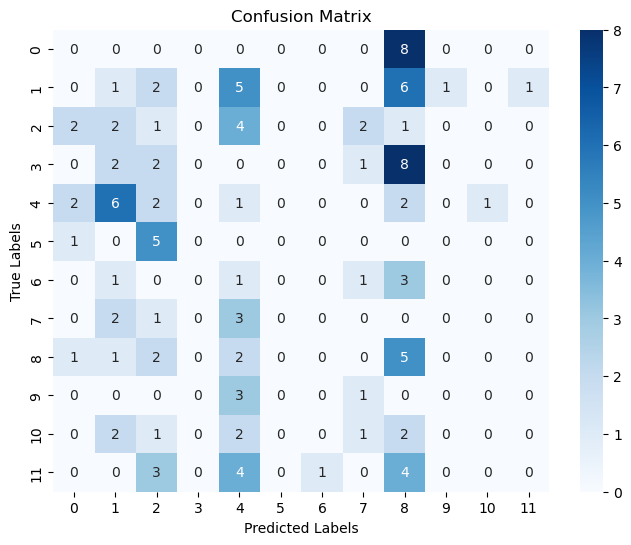

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes for test data
y_pred = np.argmax(multiclass_model.predict(X_test_1), axis=1)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test_1, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [54]:
# Evaluate the model on test data
score = multiclass_model.evaluate(X_test_1, y_test_1, verbose=0)
print("Test Accuracy: {:.2f}%".format(score[1] * 100))

Test Accuracy: 70.69%


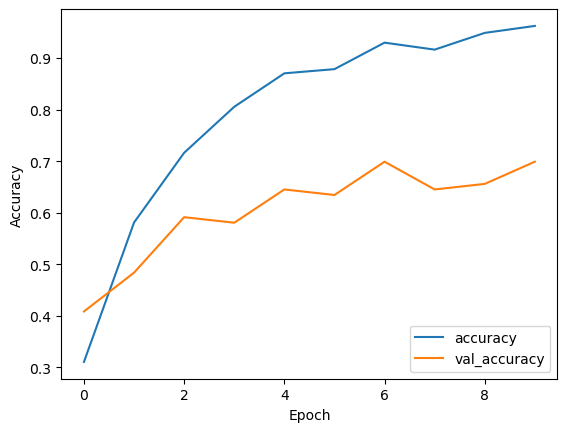

In [55]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

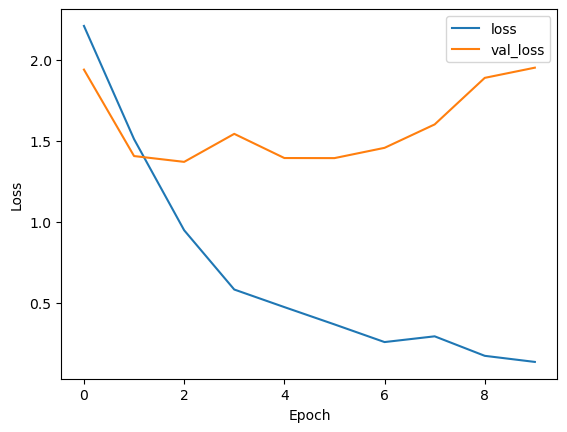

In [56]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show();

In [15]:
# Multiclass Model Hyperparameter Comparison

# Define a list of hyperparameters to tune
batch_sizes_multi = [8, 16, 32]
filter_sizes_multi = [(3, 3)]
num_filters_multi = [8, 16, 32]
dense_units_multi = [16, 32]
dropout_rates_multi = [0.3, 0.5]

# Initialize variables to store the best hyperparameters and corresponding performance
best_accuracy_multiclass = 0
best_hyperparameters_multiclass = {}

# Iterate over hyperparameter combinations
for batch_size_multi in batch_sizes_multi:
    for filter_size_multi in filter_sizes_multi:
        for num_filter_multi in num_filters_multi:
            for dense_unit_multi in dense_units_multi:
                for dropout_rate_multi in dropout_rates_multi:
                    # Build the model
                    multiclass_model_2 = Sequential([
                        Conv2D(num_filter_multi, filter_size_multi, activation='relu', input_shape=(256, 343, 1)),
                        MaxPooling2D((2, 2)),
                        Conv2D(num_filter_multi*2, filter_size_multi, activation='relu'),
                        MaxPooling2D((2, 2)),
                        Conv2D(num_filter_multi*4, filter_size_multi, activation='relu'),
                        Flatten(),
                        Dense(dense_unit_multi, activation='relu'),
                        Dropout(dropout_rate_multi),
                        Dense(12, activation='softmax')  
                    ])
                    
                    # Compile the model
                    multiclass_model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
                    
                    # Train the model
                    history_multi = multiclass_model_2.fit(X_train_1, y_train_1, epochs=10, batch_size=batch_size_multi, validation_split=0.2, verbose=0)
                    
                    # Evaluate the model on the validation set
                    accuracy_multi = history_multi.history['val_accuracy'][-1]
                    
                    # Check if this combination of hyperparameters improved performance
                    if accuracy_multi > best_accuracy_multiclass:
                        best_accuracy_multiclass = accuracy_multi
                        best_hyperparameters_multiclass = {
                            'batch_size': batch_size_multi,
                            'filter_size': filter_size_multi,
                            'num_filter': num_filter_multi,
                            'dense_unit': dense_unit_multi,
                            'dropout_rate': dropout_rate_multi
                        }

# Print the best hyperparameters and corresponding performance for the multiclass model
print("Best Hyperparameters for Multiclass Model:")
print(best_hyperparameters_multiclass)
print("Best Validation Accuracy:", best_accuracy_multiclass)


Best Hyperparameters for Multiclass Model:
{'batch_size': 16, 'filter_size': (3, 3), 'num_filter': 8, 'dense_unit': 32, 'dropout_rate': 0.3}
Best Validation Accuracy: 0.7526881694793701


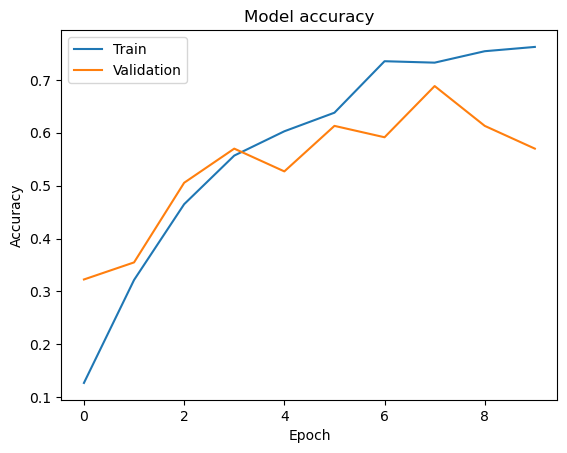

In [34]:
# Plot training & validation accuracy values
plt.plot(history_multi.history['accuracy'])
plt.plot(history_multi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

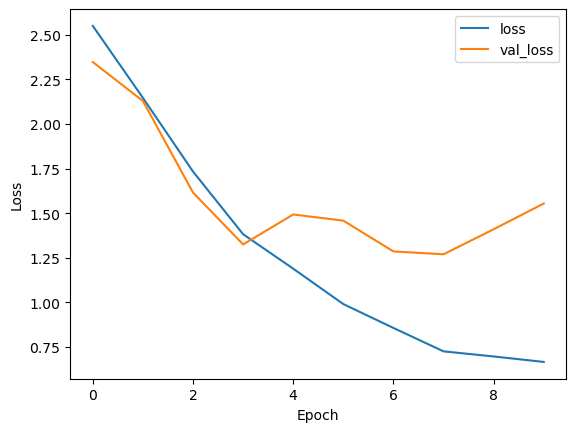

In [35]:
# Plot training & validation loss values

plt.plot(history_multi.history['loss'])
plt.plot(history_multi.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show();

# External Test

In [1]:
# Dictionary that maps each species code to its full name.

species_full_names = {
    'amecro': 'American Crow',
    'barswa': 'Barn Swallow',
    'bkcchi': 'Black-capped Chickadee',
    'blujay': 'Blue Jay',
    'daejun': 'Dark-eyes Junco',
    'houfin': 'House Finch',
    'mallar3': 'Mallard',
    'norfli': 'Northern Flicker',
    'rewbla': 'Red-winged Blackbird',
    'stejay': "Steller's Jay",
    'wesmea': 'Western Meadowlark',
    'whcspa': 'White-crowned Sparrow'
}

In [2]:
import librosa
import soundfile as sf

# Define a function to preprocess audio data
def preprocess_audio(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=22050) 
    
    # Extract spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = resize(spectrogram, (256, 343), anti_aliasing=True)
    
    # Reshape to match the input shape of the models
    spectrogram = spectrogram.reshape(1, 256, 343, 1)
    
    return spectrogram

In [3]:
# Function to predict bird species using the multi-class model
def predict_multiclass(audio_path):
    # Preprocess audio data
    spectrogram = preprocess_audio(audio_path)
    
    # Predict using the multi-class model
    prediction = multiclass_model_2.predict(spectrogram)
    
    # Convert prediction to bird species
    predicted_class = np.argmax(prediction)
    predicted_species = species_full_names[species_keys[predicted_class]]
    
    return predicted_species

In [4]:
# Define the paths to the external test audio files
import os

# Define the directory containing the external test audio files
audio_dir = 'test_birds'

# Define the paths to the external test audio files
audio_paths = [os.path.join(audio_dir, filename) for filename in os.listdir(audio_dir)]


In [30]:
# Predict bird species for each audio file using multiclass model

multiclass_predictions = [predict_multiclass(audio_path) for audio_path in audio_paths]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


In [31]:
# Print the predictions

print("\nMulti-class Model Predictions:")
for audio_path, prediction in zip(audio_paths, multiclass_predictions):
    print(f"Audio File: {audio_path}, Predicted Species: {prediction}")


Multi-class Model Predictions:
Audio File: test_birds\test1.mp3, Predicted Species: Dark-eyes Junco
Audio File: test_birds\test2.mp3, Predicted Species: Northern Flicker
Audio File: test_birds\test3.mp3, Predicted Species: Dark-eyes Junco


D:\Jupiter\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


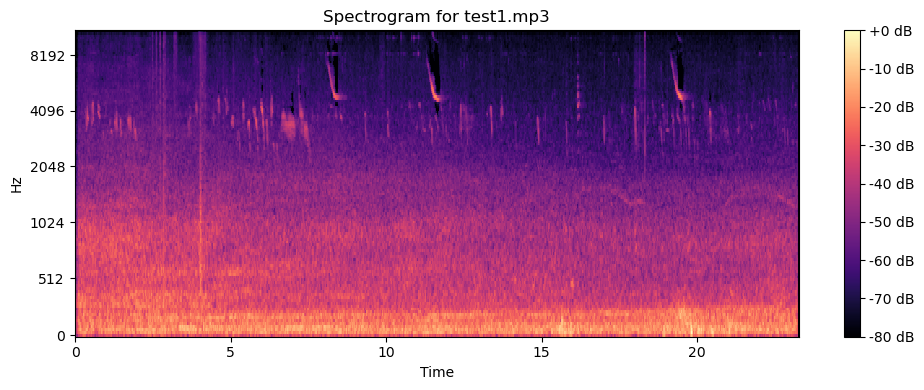

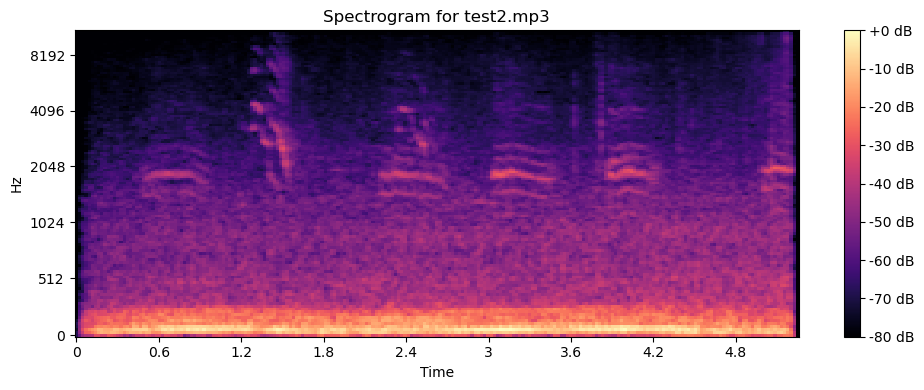

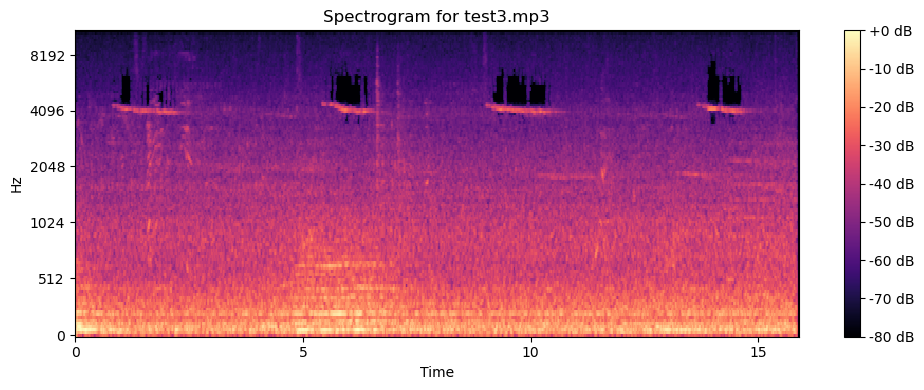

In [7]:
# Function to plot spectrogram of an audio file
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
from skimage.transform import resize

def plot_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=22050)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {os.path.basename(audio_path)}')
    plt.tight_layout()
    plt.show()

# Plot the spectrograms for the test audio files
for audio_path in audio_paths:
    plot_spectrogram(audio_path)
